In [46]:
## CNN on celeba data
import numpy as np
from sklearn.datasets import fetch_lfw_people
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import cv2
from tensorflow.keras.layers import BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

#  Step 1: Load face images
lfw = fetch_lfw_people(resize=0.5, funneled=True, color=False)
faces = lfw.images  # shape (n_faces, h, w)
faces = np.stack([cv2.resize(img, (64, 64)) for img in faces], axis=0)
faces = faces[..., None] / 255.0  # shape (n_faces, 64,64,1)
print("Faces:", faces.shape)

#  Step 2: Load non-face images (CIFAR-10 "airplane" class)
(x_cifar, y_cifar), _ = cifar10.load_data()
airplanes = x_cifar[y_cifar.flatten() == 0]  # class 0 = airplane
airplanes = np.stack([cv2.cvtColor(cv2.resize(img, (64, 64)), cv2.COLOR_BGR2GRAY)
                      for img in airplanes], axis=0)
airplanes = airplanes[..., None] / 255.0
print("Non-faces:", airplanes.shape)

#  Step 3: Select 1000 examples each
n = 1000
X_faces = faces[:n]
X_non_faces = airplanes[:n]

#  Step 4: Combine and create labels
X = np.concatenate([X_faces, X_non_faces], axis=0)
y = np.concatenate([np.ones(n), np.zeros(n)], axis=0)

#  Step 5: Shuffle
perm = np.random.permutation(len(y))
X, y = X[perm], y[perm]

print("Combined dataset:", X.shape, y.shape)

Faces: (13233, 64, 64, 1)
Non-faces: (5000, 64, 64, 1)
Combined dataset: (2000, 64, 64, 1) (2000,)


In [47]:
celeba_model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(64,64,1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [48]:
celeba_model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
history = celeba_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stop])

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step - accuracy: 0.9535 - loss: 0.1452 - val_accuracy: 0.4775 - val_loss: 7.8317
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - accuracy: 1.0000 - loss: 1.2795e-05 - val_accuracy: 0.4775 - val_loss: 14.7923
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 3.6877e-04 - val_accuracy: 0.4775 - val_loss: 22.1845
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 1.0000 - loss: 1.8057e-05 - val_accuracy: 0.4775 - val_loss: 24.6309


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


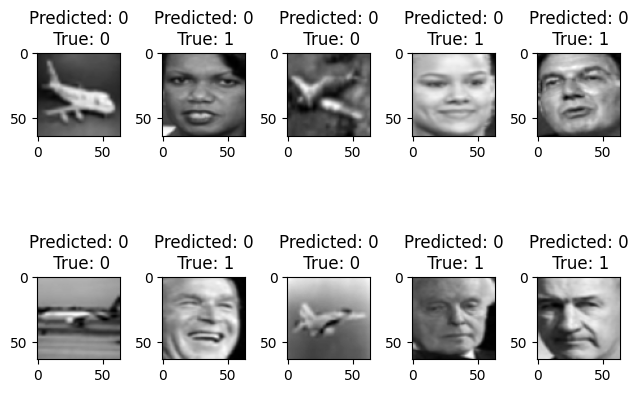

In [49]:
import matplotlib.pyplot as plt
preds = celeba_model.predict(X_test)
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(X_test[i].reshape(64,64), cmap='grey')
  plt.title(f"Predicted: {np.argmax(preds[i])}\n True: {int(y_test[i])}")

plt.tight_layout()
plt.show()

As we can see here the model correctly predicted non-faces but not faces on the new data. Certainly we need it to train it better but there might be an risk that it will memorize the data so using an concept VAE(Variational Auto Encoder) to generalize the data.

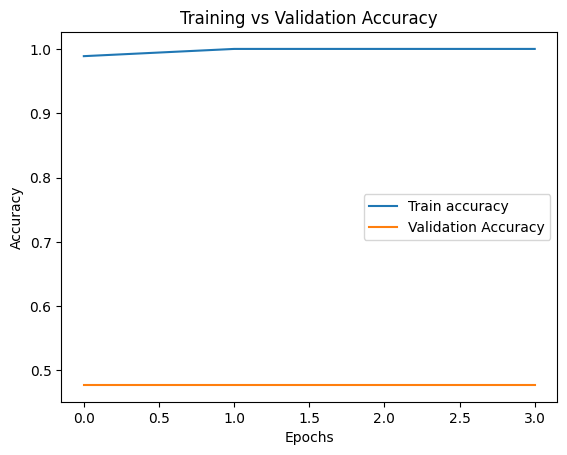

In [50]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

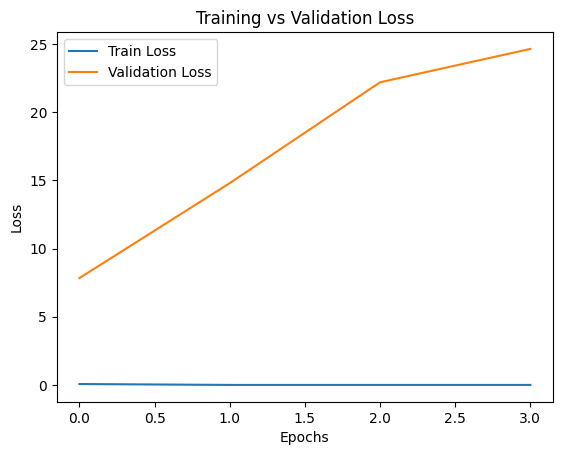

In [51]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [52]:
### Creating a VAE
# VAE ENCODER
from tensorflow.keras import layers, Model

class VAE_Encoder(Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv1 = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')
        self.conv2 = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')
        self.flatten = layers.Flatten()
        self.fc_mu = layers.Dense(latent_dim)
        self.fc_logvar = layers.Dense(latent_dim)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

In [53]:
## Reparametrization trick
class Sampler(layers.Layer):
    def call(self, mu, logvar):
        eps = tf.random.normal(shape=tf.shape(mu))
        return mu + tf.exp(0.5 * logvar) * eps

In [54]:
### Decoder
class VAE_Decoder(Model):
    def __init__(self):
        super().__init__()
        self.fc = layers.Dense(16*16*64, activation='relu')
        self.reshape = layers.Reshape((16, 16, 64))
        self.deconv1 = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')
        self.deconv2 = layers.Conv2DTranspose(1, 3, strides=2, padding='same', activation='sigmoid')

    def call(self, z):
        x = self.fc(z)
        x = self.reshape(x)
        x = self.deconv1(x)
        return self.deconv2(x)

In [55]:
### Full VAE model
class VAE(Model):
    def __init__(self, encoder, decoder, sampler):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = sampler

    def call(self, x):
        mu, logvar = self.encoder(x)
        z = self.sampler(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

In [56]:
## VAE Loss function
def vae_loss(x, x_recon, mu, logvar):
    recon_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, x_recon))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mu) - tf.exp(logvar))
    return recon_loss + kl_loss

The VAE consists of encoder, sampler, decoder in which the image is encoded into latent space z which is equal to z=mu+e^logvar but there is a problem it cannot be used for calculating gradients so we use reparametrization trick which is introducing an epsilon a randomness so final z = mu+e^(0.5*logvar)*epsilon. and later with this z value we can decode the original image.

In [57]:
X_faces = X[y == 1]  # use only face images
latent_dim = 32

encoder = VAE_Encoder(latent_dim)
decoder = VAE_Decoder()
sampler = Sampler()
vae = VAE(encoder, decoder, sampler)

optimizer = tf.keras.optimizers.Adam()

# Training loop
for epoch in range(10):
    for batch in tf.data.Dataset.from_tensor_slices(X_faces).shuffle(1000).batch(32):
        with tf.GradientTape() as tape:
            x_recon, mu, logvar = vae(batch)
            loss = vae_loss(batch, x_recon, mu, logvar)
        grads = tape.gradient(loss, vae.trainable_variables)
        optimizer.apply_gradients(zip(grads, vae.trainable_variables))
    print(f"Epoch {epoch+1} Loss: {loss.numpy():.4f}")

Epoch 1 Loss: 0.1970
Epoch 2 Loss: 0.0850
Epoch 3 Loss: 0.0351
Epoch 4 Loss: 0.0268
Epoch 5 Loss: 0.0184
Epoch 6 Loss: 0.0177
Epoch 7 Loss: 0.0171
Epoch 8 Loss: 0.0158
Epoch 9 Loss: 0.0161
Epoch 10 Loss: 0.0157


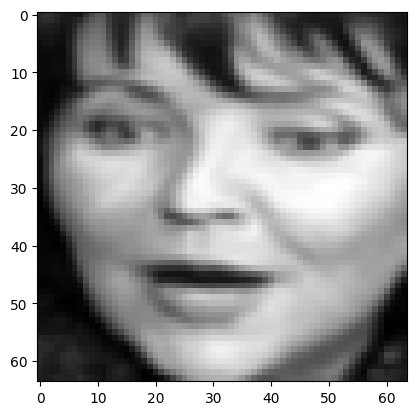

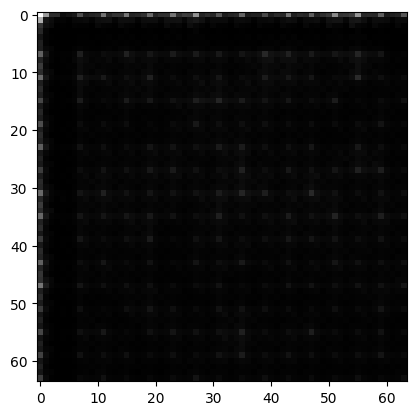

In [58]:
x_recon, mu, logvar = vae(X_faces[:10])
plt.imshow(X_faces[0].reshape(64,64), cmap='grey')
plt.show()
plt.imshow(x_recon[0].numpy().reshape(64,64), cmap='grey')
plt.show()

The above is the basic VAE used the model learnt the features good but it can be better at first we will visualize the latent space so we can get better idea

In [59]:
### Encoding all images and plotting visually
from sklearn.decomposition import PCA # PCA converts images of 32D to 2D to visualize
mu_list = []
for batch in tf.data.Dataset.from_tensor_slices(X_faces).batch(32):
  mu,logvar = encoder(batch)
  mu_list.append(mu)

mu_all = np.concatenate(mu_list, axis=0)
print("MU shape: ",mu_all.shape)

MU shape:  (1000, 32)


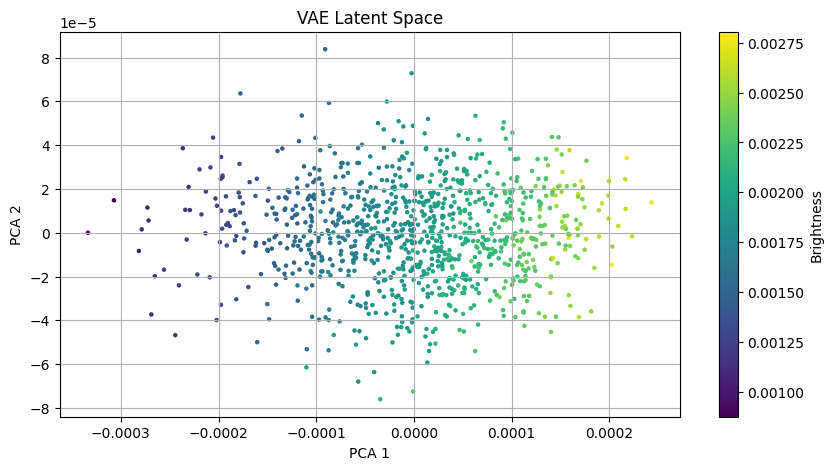

In [60]:
pca = PCA(n_components=2)
mu_reduced = pca.fit_transform(mu_all)
brightness = X_faces.mean(axis=(1,2,3)) # Calculate brightness for only face images
plt.figure(figsize=(10,5))
plt.scatter(mu_reduced[:,0], mu_reduced[:,1], s=5, c=brightness, cmap='viridis')
plt.colorbar(label='Brightness')
plt.title("VAE Latent Space")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

The above visualization says the data is imbalanced

Uneven distribution = data imbalance

Sparse regions = faces that the CNN might misclassify

This is real evidence that bias exists

so resampling it that means giving higher weights to the sparse regions making it seen more often so the model won't get biased and perfectly classifies the faces and non-faces then we again train that model on this sampled data this process is called DB-VAE(Debiasing Variational AutoEncoder)

In [62]:
## Now sampling the rare regions with giving higher weights for lower probabilities
# Assume mu_2d is your PCA output
import numpy as np

bins = 40
H, xedges, yedges = np.histogram2d(mu_reduced[:, 0], mu_reduced[:, 1], bins=bins)

# Get bin indices for each point
# Use clip to ensure indices are within the valid range [0, bins-1]
xbin = np.clip(np.digitize(mu_reduced[:, 0], xedges) - 1, 0, bins - 1)
ybin = np.clip(np.digitize(mu_reduced[:, 1], yedges) - 1, 0, bins - 1)

# Density per sample
density = H[xbin, ybin]

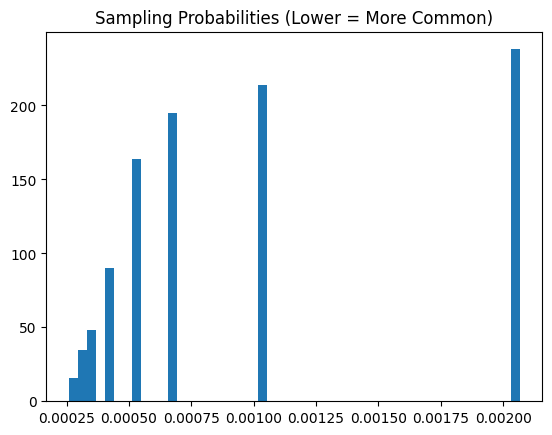

In [63]:
# Lower density → higher weight
probability = 1 / (density + 1e-5)
probability /= probability.sum()  # Normalize to sum=1

# Check distribution
plt.hist(probability, bins=50)
plt.title("Sampling Probabilities (Lower = More Common)")
plt.show()

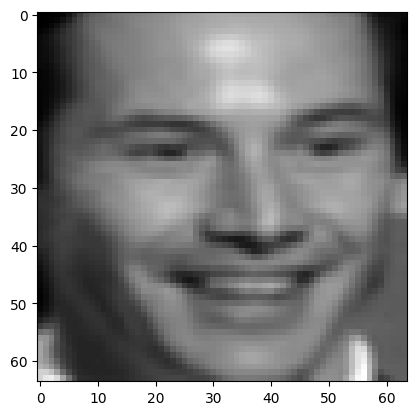

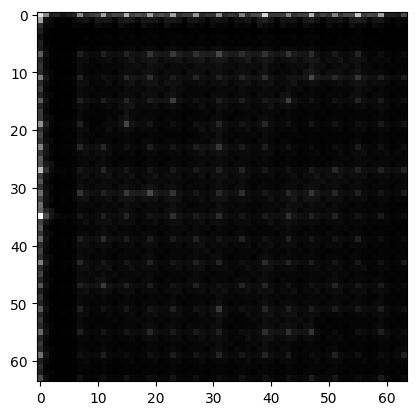

In [64]:
# Let's say we want a batch of 256
resample_indices = np.random.choice(len(X_faces), size=256, p=probability)
X_batch = X_faces[resample_indices]
x_recon, _, _ = vae(X_batch) # vae returns x_recon, mu, logvar, so we unpack it
plt.imshow(X_batch[0].reshape(64,64), cmap='grey')
plt.show()
plt.imshow(x_recon[0].numpy().reshape(64,64), cmap='grey') # Access the first image from the batch and reshape
plt.show()

Resampled face looks darker, with complex features.

This means our model is now learning diverse facial features, not just over-represented ones like bright/cropped celeb faces.

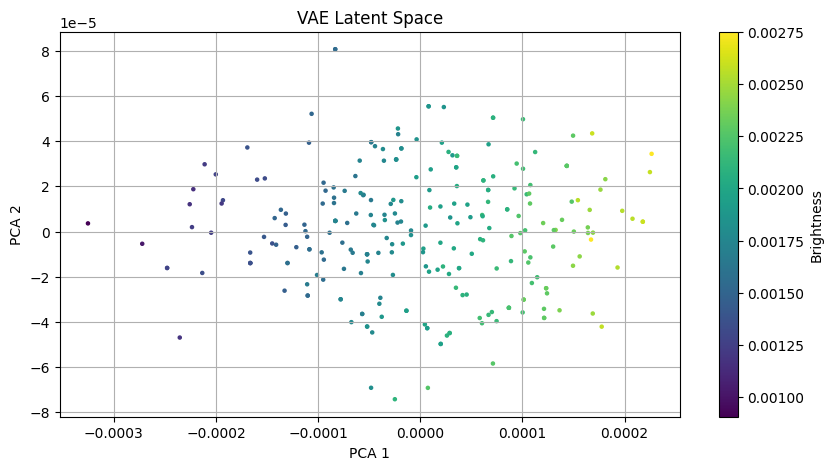

<Figure size 640x480 with 0 Axes>

In [ ]:
mu_resample = []
for batch in tf.data.Dataset.from_tensor_slices(X_batch).batch(32):
  mu,logvar = encoder(batch)
  mu_resample.append(mu)

mu_resample = np.concatenate(mu_resample, axis=0)
mu_resample = pca.fit_transform(mu_resample)
brightness = X_batch.mean(axis=(1,2,3))
plt.figure(figsize=(10,5))
plt.scatter(mu_resample[:,0], mu_resample[:,1], s=5, c=brightness, cmap='viridis')
plt.colorbar(label='Brightness')
plt.title("VAE Latent Space")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

The data is samplified and is even now, leading to de-biasing data.

In [66]:
resampled_model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(64,64,1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

resampled_model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [67]:
def dbvae_batch_sampler(X, probability, batch_size=32):
    while True:
        indices = np.random.choice(len(X), size=batch_size, p=probability)
        yield X[indices], np.ones(batch_size)  # all faces = label 1

In [68]:
# Split non-face samples
X_non = X[y == 0]

# Define function to create balanced batch
def combined_sampler(X_faces, X_non, p_faces, batch_size=32):
    half = batch_size // 2
    idx_faces = np.random.choice(len(X_faces), size=half, p=p_faces)
    idx_non = np.random.choice(len(X_non), size=half)

    X_batch = np.concatenate([X_faces[idx_faces], X_non[idx_non]])
    y_batch = np.array([1] * half + [0] * half)

    # Shuffle
    perm = np.random.permutation(batch_size)
    return X_batch[perm], y_batch[perm]

In [69]:
# Manual training loop
for epoch in range(10):
    for step in range(100):  # 100 steps per epoch
        X_batch, y_batch = combined_sampler(X_faces, X_non, probability, batch_size=32)
        loss, acc = resampled_model.train_on_batch(X_batch, y_batch)
    print(f"Epoch {epoch+1} | Loss: {loss:.4f} | Accuracy: {acc:.4f}")

Epoch 1 | Loss: 0.0183 | Accuracy: 0.9953
Epoch 2 | Loss: 0.0091 | Accuracy: 0.9977
Epoch 3 | Loss: 0.0061 | Accuracy: 0.9984
Epoch 4 | Loss: 0.0046 | Accuracy: 0.9988
Epoch 5 | Loss: 0.0037 | Accuracy: 0.9991
Epoch 6 | Loss: 0.0030 | Accuracy: 0.9992
Epoch 7 | Loss: 0.0026 | Accuracy: 0.9993
Epoch 8 | Loss: 0.0023 | Accuracy: 0.9994
Epoch 9 | Loss: 0.0020 | Accuracy: 0.9995
Epoch 10 | Loss: 0.0018 | Accuracy: 0.9995


In [70]:
X_batch, y_batch = combined_sampler(X_faces, X_non, probability, batch_size=32)
X_train, X_test, y_train, y_test = train_test_split(X_batch, y_batch, test_size=0.2, shuffle=True)

In [71]:
resampled_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 1.1760e-12 - val_accuracy: 1.0000 - val_loss: 4.9293e-21
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 1.0000 - loss: 1.2317e-14 - val_accuracy: 1.0000 - val_loss: 5.2263e-21
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 1.0000 - loss: 3.8336e-16 - val_accuracy: 1.0000 - val_loss: 5.5386e-21
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 1.0000 - loss: 1.8755e-13 - val_accuracy: 1.0000 - val_loss: 5.8670e-21
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 1.0000 - loss: 3.7710e-14 - val_accuracy: 1.0000 - val_loss: 6.2124e-21
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 1.0000 - loss: 3.6553e-14 - val_accuracy: 1.0000 - val_loss: 6.5751e-21
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 1.0000 - loss: 8.6789e-14 - val_accuracy: 1.0000 - val_loss: 6.9562e-21
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 1.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


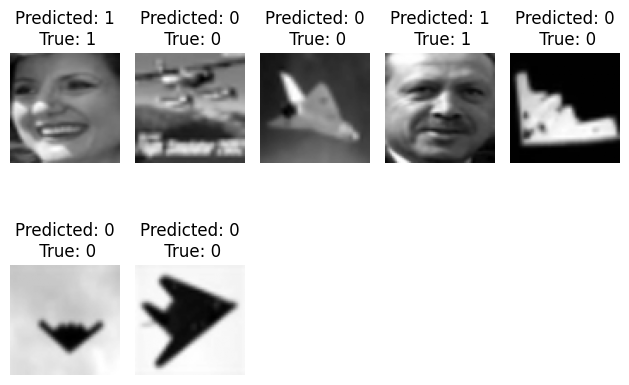

<Figure size 640x480 with 0 Axes>

In [ ]:
preds = resampled_model.predict(X_test)
for i in range(len(X_test)): # Change the loop range to the size of X_test
  plt.subplot(2,5,i+1)
  plt.imshow(X_test[i].reshape(64,64,1), cmap='grey')
  plt.title(f"Predicted: {int(preds[i]>0.5)}\n True: {int(y_test[i])}")
  plt.axis('off')

plt.tight_layout()
plt.show()

Here we used the resamplified data to train this model which resulted in a

Loss dropped from 0.0117 → 0.0012

Accuracy: 99.98% by epoch 10

Super clean, steady convergence — no overfitting or instability.